In [18]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage
import random
import cv2
import heapq
import time
import torch

from frechetdist import frdist
from refine_transform import match_fragments, Translation,check_possibility_of_translation, compute_fast_geom_morph_score,nms
from find_transform import estimate_transform_params, transform_line, estimate_mean_squared_transformation_error

from utils import build_fragment, Fragment, rotate_fragment, pad_fragment
from utils import shift_fragment, blend_fragments, transform_fragment

from shape_align import align_two_fragments, pairwise_alignment
from find_transform import find_best_transform_ransac, aligned_coords2line

from shape_utils import get_colorized_edge
from shape_utils import linearize_edge
from curvature import edge_coords2curvatures
from shape_align import water
from typing import List, Dict, Tuple
from joblib import Parallel, delayed
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
from dataclasses import dataclass
from scipy.ndimage import shift

In [2]:

from extend import extend_image, load_model

Detectron v2 is not installed


In [3]:
%matplotlib inline

# Extending fragments

In [4]:
data_dir = '../voronoi/example'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [5]:
from skimage.io import imread
from utils import preprocess

def build_fragment(mask_index, model, indir='../voronoi/example', ext_step=15, pad=10):
    fragment = imread(indir + '/' + 'fresco.jpg')
    mask = imread(indir + '/' + f'new_mask_{mask_index}.png', as_gray=True) > 0.8
    mask = mask[:,:,None]
    cropped_frag, cropped_inv_mask, pos = preprocess(fragment, mask.astype(bool))
    cropped_frag = np.pad(cropped_frag, ((pad, pad), (pad, pad), (0, 0)))
    extended = cropped_frag
    
    mask = np.invert(cropped_inv_mask)
    extended_mask = cv2.dilate(mask * 1.0, np.ones((30, 30)))
    extended_mask = np.pad(extended_mask, ((pad, pad), (pad, pad)))
    extended_masked = extended_mask[:, :, None] * extended

    mask = np.pad(mask, ((pad, pad), (pad, pad), (0, 0)))
    mask = cv2.erode(mask * 1.0, np.ones((6, 6), np.uint8))[:,:,None]

    return Fragment(cropped_frag / 255, extended_masked / 255,mask, extended_mask[:,:,None])

In [287]:
frag1 = build_fragment(5, None)
frag2 = build_fragment(3, None)

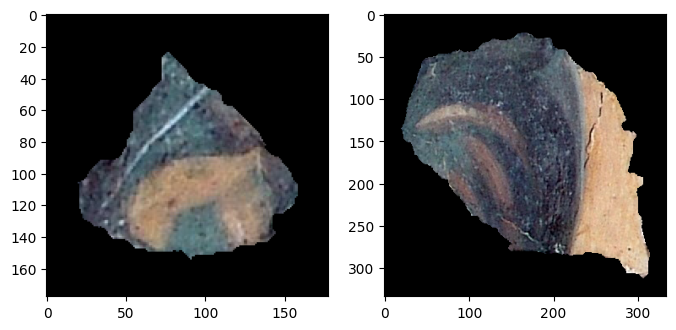

In [288]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [289]:
def extend_fragment(frag, model):
    inv_mask = np.invert(frag.mask.astype(bool))
    extended = extend_image(frag.fragment * 255, inv_mask, model) * frag.extended_mask
    return Fragment(
        frag.fragment,
        extended,
        frag.mask,
        frag.extended_mask
    )

In [290]:
model = load_model()

In [291]:
ext_frag1 = extend_fragment(frag1, model)
ext_frag2 = extend_fragment(frag2, model)

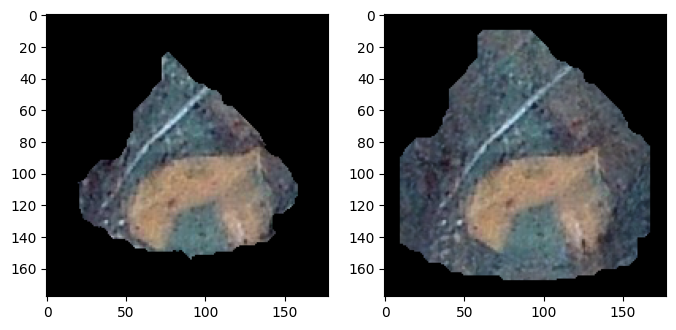

In [292]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(ext_frag1.fragment)
axes[1].imshow(ext_frag1.extended_frag)

In [299]:

frag3 = rotate_fragment(pad_fragment(ext_frag1, 200), 60)

# Matching fragments

In [300]:
def find_best_fragment_transform(palette, frag1, frag2):
    frags = [frag1, frag2]
    descriptors, alignment = pairwise_alignment(palette, frags)
    line1 = aligned_coords2line(alignment[(0, 1)], descriptors[0].edge_coords, left=True)
    line2 = aligned_coords2line(alignment[(0, 1)], descriptors[1].edge_coords[::-1], left=False)
    line1 -= frag1.fragment.shape[0] // 2
    line2 -= frag2.fragment.shape[0] // 2
    best_transform = find_best_transform_ransac(line1, line2)
    return best_transform, line1, line2

In [301]:
best_transform_params, subcurve1, subcurve2 = find_best_fragment_transform(
    palette, 
    frag3,
    frag2
)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|████████████████████████████████████████████████████████████████████████████████| 710/710 [00:02<00:00, 247.69it/s]


In [302]:
theta, shift_y, shift_x = -np.rad2deg(np.arccos(best_transform_params[0])), best_transform_params[2], best_transform_params[3]

In [303]:
def compute_fast_geom_morph_score(subcurve1, subcurve2, transform_params, max_distance=30):
    """
    subcurve1: (n, 2) array, common subcurve from frag1
    subcurve2: (n, 2) array, common subcurve from frag2
    transform_params: tuple of (theta, shift_x, shift_y)
    """
    theta, shift_x, shift_y = transform_params
    transformed_subcurve = np.zeros(subcurve1.shape)
    theta_rad = np.deg2rad(theta)
    transformed_subcurve[:, 0] = subcurve1[:, 0] * np.cos(theta_rad) - subcurve1[:, 1] * np.sin(theta_rad) + shift_y
    transformed_subcurve[:, 1] = subcurve1[:, 0] * np.sin(theta_rad) + subcurve1[:, 1] * np.cos(theta_rad) + shift_x
    score = (max_distance - np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1))) / max_distance
#     print(np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1)))
    return score ** (1 / 3) if score > 0 else 0

0.7490553016200161


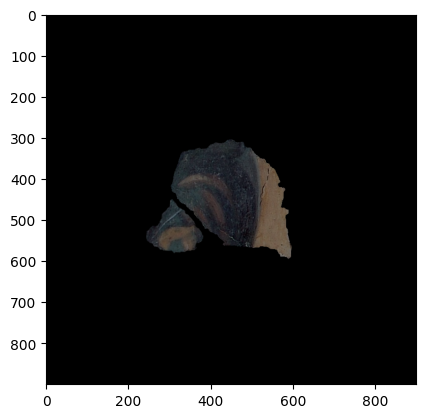

In [304]:
blended = blend_fragments(
    pad_fragment(frag2, 300),
    shift_fragment(
        rotate_fragment(pad_fragment(frag3, 300), theta - 4), 
        int(shift_x) - 10,
        int(shift_y) + 10
    )
#     transform_fragment(
#         pad_fragment(frag3, 400),
#         best_transform_params
#     )
)
plt.imshow(blended.fragment)
print(compute_fast_geom_morph_score(subcurve1, subcurve2, (theta, shift_x, shift_y)))

In [305]:
theta, shift_y, shift_x = -np.rad2deg(np.arccos(best_transform_params[0])), best_transform_params[2], best_transform_params[3]

In [306]:
def compute_content_score(frag1, frag2):
    img1, img2 = frag1.extended_frag, frag2.extended_frag
#     img1 = (img1 - img1.min()) / (img1.max() - img1.min()) - 0.5
#     img2 = (img2 - img2.min()) / (img2.max() - img2.min())
    where = np.logical_and(frag1.extended_mask, frag2.extended_mask)
    img1 = (img1 - 0.5) * where
    img2 = (img2 - 0.5) * where
#     img1, img2 = img1 / img1.max() - 0.5, img2 / img2.max() - 0.5 
    cov = (img1 * img2).sum()
    corr = cov / np.sqrt((img1 ** 2).sum() * (img2 ** 2).sum())
    return corr

In [307]:
def compute_new_content_score(frag1, frag2, features1, features2, resized_mask1, resized_mask2, shift):
    """
    frag1 - fragment
    frag2 - transformed fragment
    features1 - frag1 features from pre-trained model, shape (n_features, height, width)
    features2 - frag2 features from pre-trained model, shape (n_features, height, width)
    shift - translation (shift_x, shift_y)
    """
    img_cross_corr = compute_content_score(frag1, frag2)
    pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
    padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
    padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
    shifted_features2 = padded_features2[:, pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
#     where = np.logical_and(frag1.extended_mask, frag2.extended_mask)[:, None, None]
    
    where = np.logical_and(resized_mask1, resized_mask2).transpose(2, 0, 1)
    features1_masked = features1 * where
    features2_masked = shifted_features2 * where
    features_cov = (features1_masked * features2_masked).sum()
    features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())
    cross_corr = (img_cross_corr + features_cross_corr) / 2
    return cross_corr
    

In [308]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [309]:
def match_fragments(frag1, frag2, initial_params, subcurve1, subcurve2, beta=0.5):
    """
    initial_params: (angle, x, y)
    frag1, frag2: Fragments
    subcurve1, subcurve2: common subcurves from frag1 and frag2
    """
    theta, x_initial, y_initial = initial_params
    print(theta, x_initial, y_initial)
#     size = max(max(frag1.mask.shape[0], frag1.mask.shape[1]), max(frag2.mask.shape[0], frag2.mask.shape[1]))
    size = 200
    padded_frag1 = pad_fragment(frag1, size)
    padded_frag2 = pad_fragment(frag2, size)
    
    tensor1 = torch.tensor(padded_frag1.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
    features1 = feature_extractor(tensor1)
    features1 = features1.squeeze(0).detach().numpy()
    
    resized_mask1 = skimage.transform.resize(
        padded_frag1.extended_mask,
        (padded_frag1.fragment.shape[0] // 2, padded_frag1.fragment.shape[1] // 2)
    )
    
    
    global_res = []
    shifts = [(x, y) for x in range(x_initial - 15, x_initial + 15, 3) for y in range(y_initial - 15, y_initial + 15, 3)]
    for phi in np.arange(theta - 8, theta + 8, 2):
        rot_frag2 = rotate_fragment(padded_frag2, phi)
        tensor2 = torch.tensor(rot_frag2.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
        features2 = feature_extractor(tensor2)
        features2 = features2.squeeze(0).detach().numpy()
        resized_mask2 = skimage.transform.resize(
            rot_frag2.extended_mask, 
            (rot_frag2.fragment.shape[0] // 2, rot_frag2.fragment.shape[1] // 2)
        )
        
        # compute geom score
        for (x, y) in tqdm(shifts):
            transformed2 = shift_fragment(rot_frag2, x, y)
            if check_possibility_of_translation(padded_frag1, transformed2):
                geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, x, y))
                prob = geom_score
                print(prob)
                # prob = estimate_probability_of_neighbourhood(frag1, transformed2)
                if prob > 0.5:
                    # compute content score
#                 prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
#                     content_score = compute_content_score(padded_frag1, transformed2)
                    content_score = compute_new_content_score(
                        padded_frag1, transformed2,
                        features1, features2,
                        resized_mask1, resized_mask2,
                        (x, y)                        
                    )
                    prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
                    
#                     prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
                    print(geom_score, content_score, prob)
                    trans = Translation(x, y, phi, prob)
#                     heapq.heappush(global_res, trans)
                    global_res.append(trans)
#         global_res.extend(res)
    filtered_res = nms(sorted(global_res, reverse=True, key=lambda val: val.confidence).copy())
    return filtered_res

In [310]:
start_time = time.time()
res = match_fragments(
    pad_fragment(frag2, 200),
    pad_fragment(frag3, 200),
    (theta, int(shift_x), int(shift_y)),
    subcurve1,
    subcurve2
)
print("--- %s seconds ---" % (time.time() - start_time))

-60.000000000000185 -126 56


 14%|███████████▎                                                                     | 14/100 [00:00<00:00, 136.69it/s]

0
0
0
0
0
0
0
0
0
0.2107517032906605
0.3511016070433664
0.40748607974165363
0.43398885748248445
0.43975733704273384
0.42626663206464177
0.38981897700119905
0.3141030422640809
0.5172582245680487
0.5172582245680487 0.8328137530582813 0.6920786095515711
0.5490891447993524
0.5490891447993524 0.8356699007573776 0.7118303392629873
0.5659887455820378
0.5659887455820378 0.8384872689491146 0.7225316084999515
0.5698194222479098
0.5698194222479098 0.8434452084683608 0.7270667030005464
0.5609445012677359


 28%|██████████████████████▉                                                           | 28/100 [00:01<00:03, 22.08it/s]

0.5609445012677359 0.8485263497159875 0.7246840461988405
0.538490737732209
0.538490737732209 0.8482118090847474 0.7117532662714097
0.4996895636480754


 35%|████████████████████████████▋                                                     | 35/100 [00:01<00:03, 20.54it/s]

0.6405915368087789
0.6405915368087789 0.8359776526137958 0.7588278999189424
0.6548061574677859
0.6548061574677859 0.8371430788749941 0.7660394532735355
0.6580718569916313
0.6580718569916313 0.8413335651448766 0.7698685129903448
0.6505303192237903
0.6505303192237903 0.8440011519223354 0.7678776545042092
0.6306823377514883
0.6306823377514883 0.847064252953138 0.7601325177264414
0.5323520049144335


 40%|████████████████████████████████▊                                                 | 40/100 [00:02<00:04, 13.02it/s]

0.5323520049144335 0.847750569618033 0.7079410725676428
0.7243389495449892


 46%|█████████████████████████████████████▋                                            | 46/100 [00:02<00:03, 13.92it/s]

0.7243389495449892 0.83878793996821 0.796820785193973
0.7274404707803667
0.7274404707803667 0.8399550037795773 0.7987724760339635
0.6991195987346451


 49%|████████████████████████████████████████▏                                         | 49/100 [00:03<00:04, 11.40it/s]

0.6991195987346451 0.8392207670706933 0.7866719787920828
0.62395996098916
0.62395996098916 0.8416442656177723 0.7539643810785766
0.5239756829273168


 57%|██████████████████████████████████████████████▋                                   | 57/100 [00:03<00:02, 14.89it/s]

0.5239756829273168 0.8444235535428433 0.7014319471456523
0.7422199924194045
0.7422199924194045 0.8402925776521248 0.8048434826586306
0.6819701030576896
0.6819701030576896 0.8387524110456088 0.779052052579954
0.6056016780013309


 60%|█████████████████████████████████████████████████▏                                | 60/100 [00:04<00:03, 11.40it/s]

0.6056016780013309 0.8391026287002887 0.7435406672187693
0.5005263963718792
0.5005263963718792 0.8434061508531523 0.6866193083287119


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [00:04<00:01, 16.51it/s]

0.6481779171349623
0.6481779171349623 0.8394551424679573 0.7642759003947527
0.570121177293833


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [00:04<00:01, 16.49it/s]

0.570121177293833 0.8397603739635287 0.7254007777036519
0.45493768266072826
0.5106494026398275


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.72it/s]

0.5106494026398275 0.8415462642318569 0.6920625405039147
0.3685952597999826
0



 14%|███████████▎                                                                     | 14/100 [00:00<00:00, 138.31it/s]

0
0
0
0
0
0
0
0
0
0
0.313446573577885
0.39308397012481633
0.4321796795533344
0.4482963412909255
0.44567904371520883
0.42371523393509014
0.37601218585535306
0.43258035874265377
0.49855602149887274
0.5396563211043804
0.5396563211043804 0.8342561561796372 0.7058198406272375
0.5640916808693712
0.5640916808693712 0.8358077196271188 0.7201746269440867
0.574897147554503


 28%|██████████████████████▉                                                           | 28/100 [00:01<00:03, 22.38it/s]

0.574897147554503 0.8405920004736525 0.7283821402939828
0.5731146454403514
0.5731146454403514 0.8452510496929919 0.7297472324230927
0.5585832471068113
0.5585832471068113 0.8495198169396965 0.723848335858122
0.5158764412137979
0.5158764412137979 0.8507183379008343 0.6993980208978151
0.5993979509255377


 35%|████████████████████████████▋                                                     | 35/100 [00:01<00:03, 16.26it/s]

0.5993979509255377 0.830757864728808 0.7360552403687055
0.6321784063125064
0.6321784063125064 0.8344797340331758 0.7540464299630254
0.6525946102850799
0.6525946102850799 0.8364165547464959 0.7646238283515152
0.6618317964972957
0.6618317964972957 0.839484062773981 0.7705399729624289
0.660299328664064
0.660299328664064 0.8427213055960052 0.7716588232983365
0.6293671069853379


 42%|██████████████████████████████████▍                                               | 42/100 [00:02<00:04, 12.26it/s]

0.6293671069853379 0.8469935442530703 0.7594569732482541
0.5307738592307057
0.5307738592307057 0.8485128932088541 0.7073625729735048
0.7025646477426978


 45%|████████████████████████████████████▉                                             | 45/100 [00:02<00:04, 12.97it/s]

0.7025646477426978 0.8340497690403905 0.7850741704435836
0.7216766697615594
0.7216766697615594 0.8366979756341966 0.7944892353577536
0.7304576905852623


 48%|███████████████████████████████████████▎                                          | 48/100 [00:03<00:04, 10.40it/s]

0.7304576905852623 0.8381029764811414 0.7988610825600972
0.7045497082049431
0.7045497082049431 0.8396337260802589 0.7891959506415306
0.629910807406351


 50%|█████████████████████████████████████████                                         | 50/100 [00:03<00:05,  9.29it/s]

0.629910807406351 0.8409139902639078 0.7564504680451457
0.5314482965497475
0.5314482965497475 0.843923846030528 0.7056278837590949


 57%|██████████████████████████████████████████████▋                                   | 57/100 [00:03<00:03, 14.09it/s]

0.7562018511634795
0.7562018511634795 0.8398657234133567 0.8099939673033647
0.694694989646152
0.694694989646152 0.8387157315524784 0.7845026565988232
0.6191602809868625


 61%|██████████████████████████████████████████████████                                | 61/100 [00:04<00:03, 10.95it/s]

0.6191602809868625 0.8374154611642544 0.7493646395171759
0.5179833374985138
0.5179833374985138 0.8421754240715897 0.6968048431524306


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [00:04<00:01, 16.38it/s]

0.6729521784331121
0.6729521784331121 0.8400694035427962 0.7758462778300013
0.5964493293994558


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [00:04<00:01, 16.45it/s]

0.5964493293994558 0.8400095515984434 0.7393690445700425
0.4885455225526467
0.5542211554463985


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.11it/s]

0.5542211554463985 0.8416144731461707 0.7175799436692124
0.4331219376826114
0.31617538795989564



 15%|████████████▏                                                                    | 15/100 [00:00<00:00, 145.99it/s]

0
0
0
0
0
0
0
0
0
0
0.23793080448998674
0.36517102915014593
0.4206063532853565
0.4478157124480345
0.45525449819434854
0.44462271308694395
0.4134233567124904
0.3834915807147436
0.47085037475952124
0.5233511620131267
0.5233511620131267 0.8330291361604047 0.695791035529693
0.5561211195213657
0.5561211195213657 0.8335074403799982 0.7146825140596209
0.5741200705712487
0.5741200705712487 0.8372286491995815 0.7262815313454307
0.5792433174657363
0.5792433174657363 0.8426506174783026 0.7317335258412366
0.5719470708124407


 30%|████████████████████████▌                                                         | 30/100 [00:00<00:02, 26.59it/s]

0.5719470708124407 0.8492651883234017 0.7311027214525024
0.49538319012751747
0.5780530691128344
0.5780530691128344 0.8285760597975866 0.7239863412436405
0.6185212374126327
0.6185212374126327 0.8307969526083387 0.7455108249924115
0.6454682600133046
0.6454682600133046 0.8343876186037947 0.760219179607917
0.6607769856297703
0.6607769856297703 0.8372586792351946 0.768813263342618
0.665198245930578


 38%|███████████████████████████████▏                                                  | 38/100 [00:02<00:04, 14.00it/s]

0.665198245930578 0.8394361938724222 0.7720293192271568
0.6214264933741532
0.6214264933741532 0.8442061163057983 0.754092750569304
0.520576007910428


 43%|███████████████████████████████████▎                                              | 43/100 [00:02<00:04, 14.13it/s]

0.520576007910428 0.8486121005320327 0.7013051455522835
0.6896257423470337
0.6896257423470337 0.8322480672067316 0.7785753662093503
0.7145897379784275


 47%|██████████████████████████████████████▌                                           | 47/100 [00:03<00:04, 12.29it/s]

0.7145897379784275 0.8339332243250974 0.7899564049829245
0.7290819320745773
0.7290819320745773 0.8363579391356842 0.7972556128662682
0.7041464209118636
0.7041464209118636 0.8392396432290672 0.7887951720349204
0.6292626990950859


 50%|█████████████████████████████████████████                                         | 50/100 [00:03<00:04, 10.04it/s]

0.6292626990950859 0.8405457987779372 0.7559402255855102
0.5303826989031772
0.5303826989031772 0.8427507311459249 0.7044548777222478


 56%|█████████████████████████████████████████████▉                                    | 56/100 [00:03<00:03, 12.92it/s]

0.7716153925595751
0.7716153925595751 0.8345153634116319 0.8124394189014833
0.7626367261533279
0.7626367261533279 0.8375701195018341 0.8110080686024811
0.700987914202748
0.700987914202748 0.8382711975818256 0.7869015847528894
0.625827876209042


 61%|██████████████████████████████████████████████████                                | 61/100 [00:04<00:03, 10.83it/s]

0.625827876209042 0.8375797568761979 0.7526878967013803
0.5261021544905485
0.5261021544905485 0.839007550216009 0.7001918018691032


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [00:04<00:02, 14.53it/s]

0.7492280501887573
0.7492280501887573 0.837245780114566 0.8056953183149971
0.6874166627631016


 69%|████████████████████████████████████████████████████████▌                         | 69/100 [00:04<00:02, 11.89it/s]

0.6874166627631016 0.8392736364802205 0.7817111262928387
0.6109218606934086
0.6109218606934086 0.8405525021203843 0.746963982118772
0.5071900472827472


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [00:05<00:02, 11.84it/s]

0.5071900472827472 0.8409798205879409 0.68968278038802
0.6609355854085255


 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [00:05<00:01, 17.31it/s]

0.6609355854085255 0.8379678873252296 0.7692834251815274
0.5833414381937767


 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [00:05<00:01, 15.81it/s]

0.5833414381937767 0.8410173010828271 0.7330779477904529
0.47079138634738427
0.5310288561762179


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.11it/s]

0.5310288561762179 0.8384352751412495 0.7028176290035318
0.40238713095818407
0.2160005541153539



 15%|████████████▏                                                                    | 15/100 [00:00<00:00, 143.29it/s]

0
0
0
0
0
0
0
0
0
0
0
0.3166202599340035
0.397729209092039
0.43826478918242207
0.45602396707853654
0.45549226272192705
0.39793932740955634
0.302251970847916
0.43114326197858727
0.49915155896838936
0.5417123226175934
0.5417123226175934 0.8306249555639604 0.7052478269865463
0.567457543191278
0.567457543191278 0.835423375452072 0.7218058805752322
0.579573734262888


 30%|████████████████████████▌                                                         | 30/100 [00:00<00:02, 31.78it/s]

0.579573734262888 0.8397094275250498 0.7304277703441009
0.578542288424317
0.578542288424317 0.8467786587475358 0.7334291896546379
0.4631677168770534
0.5497239715983809
0.5497239715983809 0.8253014945249629 0.7071383003598026
0.5992364500802716
0.5992364500802716 0.8270594912524973 0.7340354501034684
0.6332847352872135
0.6332847352872135 0.8300796257914578 0.7521670035264457
0.6548901633219598
0.6548901633219598 0.8336284519497428 0.7641123968038419
0.6653073252333128


 38%|███████████████████████████████▏                                                  | 38/100 [00:01<00:03, 16.63it/s]

0.6653073252333128 0.835596747036609 0.7699091197452071
0.606592290846446
0.606592290846446 0.8400933619557593 0.7445570024213481
0.5009600391049144


 43%|███████████████████████████████████▎                                              | 43/100 [00:02<00:03, 16.13it/s]

0.5009600391049144 0.8449594271365148 0.6875774620407548
0.6262448082011846
0.6262448082011846 0.8230181687443867 0.7449900100398439
0.6720014571805524
0.6720014571805524 0.8278537816375661 0.7684470369769032
0.7030465377431108
0.7030465377431108 0.830801057086143 0.783351967666937
0.7233118179546855


 47%|██████████████████████████████████████▌                                           | 47/100 [00:02<00:04, 12.19it/s]

0.7233118179546855 0.8326801735610495 0.7927254904907163
0.6979060039989965
0.6979060039989965 0.8354648301083225 0.7839581952871294
0.6219953263534925


 50%|█████████████████████████████████████████                                         | 50/100 [00:03<00:04, 10.41it/s]

0.6219953263534925 0.8381534508143744 0.7511404157261463
0.5207018565453678
0.5207018565453678 0.8400919446650918 0.6974835686482735
0.7285220968317493


 55%|█████████████████████████████████████████████                                     | 55/100 [00:03<00:03, 12.67it/s]

0.7285220968317493 0.8269633242732797 0.7913210227259853
0.7598858279189074
0.7598858279189074 0.8306823916810295 0.8056619242650433
0.7634936225255844


 57%|██████████████████████████████████████████████▋                                   | 57/100 [00:03<00:03, 10.96it/s]

0.7634936225255844 0.8329172526084503 0.8084145071405419
0.7014209979351999


 59%|████████████████████████████████████████████████▍                                 | 59/100 [00:04<00:04,  8.57it/s]

0.7014209979351999 0.8359076075301035 0.7856928001659591
0.62583393672656
0.62583393672656 0.8363821340526989 0.7520456718187627
0.5255268304096509


 61%|██████████████████████████████████████████████████                                | 61/100 [00:04<00:04,  9.05it/s]

0.5255268304096509 0.8367683833001416 0.6988120055582555
0.7566977591719035


 67%|██████████████████████████████████████████████████████▉                           | 67/100 [00:04<00:02, 13.31it/s]

0.7566977591719035 0.8342779612411153 0.8067087726900655
0.6945721013690315
0.6945721013690315 0.8362297430983986 0.782998988971479
0.6183395602731353


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [00:05<00:02, 11.13it/s]

0.6183395602731353 0.8391980011672744 0.7499133512231154
0.5160727774138808
0.5160727774138808 0.8386123657555993 0.6940262147346593


 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [00:05<00:01, 16.90it/s]

0.6771975008530595
0.6771975008530595 0.8352300962323015 0.7749487357515875
0.5990466179842799


 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [00:05<00:01, 15.63it/s]

0.5990466179842799 0.8381181609500082 0.7397147229626065
0.49104635565689414
0.5655886597804257


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.13it/s]

0.5655886597804257 0.8365628910147236 0.7213612068424267
0.44601341640512987
0.35552356168318766



 15%|████████████▏                                                                    | 15/100 [00:00<00:00, 140.68it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0.21648189038682022
0.3594532026993627
0.41855297982866707
0.4480638390227089
0.4575114928123139
0.3080270179342872
0
0.3722328503199539
0.46504614934556665
0.5200941333708535
0.5200941333708535 0.8313402306440868 0.693083504841817
0.5546323246661544
0.5546323246661544 0.8349256953003235 0.714554694584843
0.5741184075062066


 30%|████████████████████████▌                                                         | 30/100 [00:00<00:02, 29.96it/s]

0.5741184075062066 0.8390532053670365 0.7271951529042396
0.5462783071701085
0.5462783071701085 0.8452720493685282 0.7148523389217181
0.4143829849360638
0.5105354664473426
0.5105354664473426 0.8228849284347745 0.6834956566715904
0.5736303729716473
0.5736303729716473 0.8249261234266756 0.7198141624477002
0.6157533289899012


 37%|██████████████████████████████▎                                                   | 37/100 [00:01<00:03, 19.72it/s]

0.6157533289899012 0.8268274369091986 0.7420395183287508
0.6440672961694972
0.6440672961694972 0.8305919118471867 0.7574697618971147
0.6606282517847837


 42%|██████████████████████████████████▍                                               | 42/100 [00:01<00:03, 18.19it/s]

0.6606282517847837 0.8331627494124105 0.7664397491361384
0.5842639379234961
0.5842639379234961 0.8376813684766098 0.7318683479144749
0.47002516005186207
0.649398949913679
0.649398949913679 0.8230412345828217 0.7556870426310365
0.6869566370520349


 46%|█████████████████████████████████████▋                                            | 46/100 [00:02<00:03, 16.35it/s]

0.6869566370520349 0.8263084370806194 0.7739739075645051
0.7131337354437151
0.7131337354437151 0.8286234939579631 0.7861835140616407
0.6857610149286898


 49%|████████████████████████████████████████▏                                         | 49/100 [00:02<00:04, 12.58it/s]

0.6857610149286898 0.8323420577370099 0.776982216137391
0.6078650665580575
0.6078650665580575 0.8340394626886147 0.7420104013693627
0.5016500306895272


 56%|█████████████████████████████████████████████▉                                    | 56/100 [00:03<00:02, 15.18it/s]

0.5016500306895272 0.8376843109553739 0.6847820654219469
0.7440298673061511
0.7440298673061511 0.82678728691151 0.7972290561553925
0.7587648762053619
0.7587648762053619 0.8301882301248854 0.8049318627838675
0.6959986397583664


 58%|███████████████████████████████████████████████▌                                  | 58/100 [00:03<00:03, 12.21it/s]

0.6959986397583664 0.8341224756905417 0.7823677595706567
0.6191786597765238
0.6191786597765238 0.8350837351619176 0.7481274089218956
0.5162141350300189


 60%|█████████████████████████████████████████████████▏                                | 60/100 [00:03<00:03, 10.24it/s]

0.5162141350300189 0.8356121942635736 0.6927389973404463
0.695816753647125


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [00:03<00:01, 16.61it/s]

0.695816753647125 0.8338194168142664 0.7821134027825669
0.6189788855821049
0.6189788855821049 0.8385073651755086 0.7498585148849951
0.5159599340108163


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [00:04<00:02, 13.99it/s]

0.5159599340108163 0.837160888335515 0.693295046615138
0.6072532297090029


 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [00:04<00:00, 18.96it/s]

0.6072532297090029 0.8355513531774232 0.7425028523888507
0.5008522688726589
0.5008522688726589 0.8398794411659987 0.6852614844143609


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.84it/s]


0.46854647380046094
0.41180577309618993


 15%|████████████▏                                                                    | 15/100 [00:00<00:00, 140.90it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.2934266846486195
0.3858204872419047
0.4305380884240845
0.42244976317012073
0
0
0.26470644914304453
0.4167305831993051
0.48978349140643584
0.5350319371137987
0.5350319371137987 0.8348644632956479 0.7034581966563218
0.5626629198833696
0.5626629198833696 0.838584706689663 0.7207668197824703
0.5024166254440623


 30%|████████████████████████▌                                                         | 30/100 [00:00<00:02, 35.00it/s]

0.5024166254440623 0.8457398499052986 0.688835952296305
0.3347519484000673
0.454602287337094
0.540450224219307
0.540450224219307 0.823452439143548 0.7010807580953639
0.5923420435972162
0.5923420435972162 0.8253943901700429 0.7296965845155146
0.6280821302920033


 38%|███████████████████████████████▏                                                  | 38/100 [00:01<00:02, 21.63it/s]

0.6280821302920033 0.8307834314568967 0.7500910005038897
0.63911229443099
0.63911229443099 0.8335730800882131 0.7568151224296813
0.5532569949200882


 43%|███████████████████████████████████▎                                              | 43/100 [00:01<00:02, 22.16it/s]

0.5532569949200882 0.8385412086017972 0.7155510901068076
0.42343305629621925
0.6661149505489599


 47%|██████████████████████████████████████▌                                           | 47/100 [00:01<00:02, 18.86it/s]

0.6661149505489599 0.8238789060580796 0.7635951232318797
0.6984936714530321
0.6984936714530321 0.8268975725439327 0.7791537017259808
0.6675282548866904
0.6675282548866904 0.8305530696567824 0.7680299068375839
0.5863097480123022
0.5863097480123022 0.8323805996716598 0.7302236952876707


 50%|█████████████████████████████████████████                                         | 50/100 [00:02<00:03, 15.17it/s]

0.47140048136475604
0.7484874284552663


 57%|██████████████████████████████████████████████▋                                   | 57/100 [00:02<00:02, 18.86it/s]

0.7484874284552663 0.8274094643827103 0.7993156423428218
0.6846594566244927
0.6846594566244927 0.8322849565995452 0.7764772409053609
0.6056330424519865


 60%|█████████████████████████████████████████████████▏                                | 60/100 [00:02<00:02, 15.56it/s]

0.6056330424519865 0.8340473666905661 0.7409035184960163
0.4974128590045462
0.6911654246864


 68%|███████████████████████████████████████████████████████▊                          | 68/100 [00:03<00:01, 20.65it/s]

0.6911654246864 0.8322748928302168 0.7792442945441775
0.6128621622938693
0.6128621622938693 0.8372596073395305 0.7461881676548767
0.5068423816091381


 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [00:03<00:01, 16.20it/s]

0.5068423816091381 0.8366726963894662 0.6875339354514882
0.5011680273991489


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.75it/s]

0.5011680273991489 0.8382545210549934 0.6847362530596295



 13%|██████████▌                                                                      | 13/100 [00:00<00:00, 122.38it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.33253146430873026
0.40119091601340673
0.3104517520497356
0
0
0
0.3424973706111447


 26%|█████████████████████                                                            | 26/100 [00:00<00:00, 120.08it/s]

0.4478001219958186
0.5074856647279515
0.5074856647279515 0.8343282469802913 0.6868702568505266
0.5446992624270324
0.5446992624270324 0.8394450430510414 0.711169796358145
0.44097303032498264
0
0.493140247639846
0.5620979766011608
0.5620979766011608 0.8252998969943495 0.7138759523025464
0.6065123489306362
0.6065123489306362 0.8291850957541347 0.7387747356266336
0.6059394261116487


 39%|███████████████████████████████▉                                                  | 39/100 [00:01<00:02, 22.27it/s]

0.6059394261116487 0.8334031363964758 0.7407171544035077
0.5112108671123561
0.5112108671123561 0.8392213539120711 0.6913555215279912
0.34903620090417686
0.6390486874511947
0.6390486874511947 0.8214004760427179 0.7500577757446958
0.6792489169035033


 47%|██████████████████████████████████████▌                                           | 47/100 [00:01<00:02, 21.35it/s]

0.6792489169035033 0.8257329385959358 0.7703556940219227
0.642802110612583
0.642802110612583 0.8295203834714266 0.7562922564102276
0.5562155451235697


 53%|███████████████████████████████████████████▍                                      | 53/100 [00:02<00:02, 19.52it/s]

0.5562155451235697 0.8328843473417014 0.7144289491514347
0.42579549674714734
0.667230849551882


 62%|██████████████████████████████████████████████████▊                               | 62/100 [00:02<00:01, 20.43it/s]

0.667230849551882 0.8302267718780687 0.7677126594613384
0.5846499348459807
0.5846499348459807 0.8327328250592139 0.7295443174200835
0.4672665443705283


 69%|████████████████████████████████████████████████████████▌                         | 69/100 [00:02<00:01, 23.56it/s]

0.5997660738357091
0.5997660738357091 0.8348129277781734 0.7383592067881922
0.4879310170758043


 30%|████████████████████████▎                                                        | 30/100 [00:00<00:00, 142.00it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0.22677679646723772
0.35441342722183683
0
0
0
0.1356547254177069
0.3871318767421946
0.4697225381074504
0.4951412284824006
0.34335702805801316
0
0.5232666838003948
0.5232666838003948 0.8220802640357657 0.6906198364875497
0.5786007172169175
0.5786007172169175 0.826660965342445 0.7232960725950147
0.5635392027566896


 45%|████████████████████████████████████▉                                             | 45/100 [00:00<00:01, 36.71it/s]

0.5635392027566896 0.8321346558137334 0.7180543705734136
0.45291121745503315
0.16179577074159673
0.6550963641430371
0.6550963641430371 0.8235202552222629 0.7585159707476783
0.6107646767735386
0.6107646767735386 0.8283856409864725 0.7404434178150936
0.515372331638213


 54%|████████████████████████████████████████████▎                                     | 54/100 [00:01<00:01, 26.39it/s]

0.515372331638213 0.8332492538097244 0.6911507706683216
0.3533797788448831
0.555138239619553


 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [00:01<00:00, 42.93it/s]

0.555138239619553 0.8317959621630353 0.7133025570731893
0.42150718349187255
0.45721874694559494


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.55it/s]

--- 36.72799301147461 seconds ---


In [311]:
def visualize_fragment(frag):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
    axes[0][0].imshow(frag.fragment)
    axes[0][1].imshow(frag.mask * 255)
    axes[1][0].imshow(frag.extended_frag)
    axes[1][1].imshow(frag.extended_mask * 255)

In [312]:
padded_frag2 = pad_fragment(frag2, 200)

0.8124394189014833
0.6771826156706149


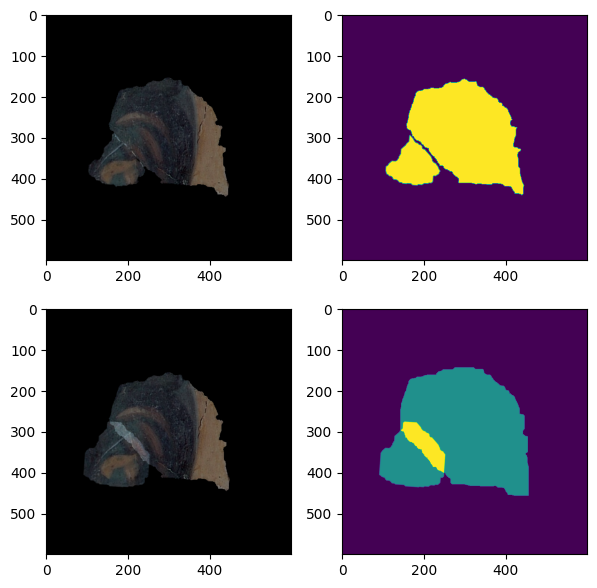

In [313]:
tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
# corr = compute_geom_morph_score(padded_frag0, shift_fragment(padded_frag1, y, x))
print(tr.confidence)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(frag3, tr.angle), x, y)
print(compute_content_score(padded_frag2, transformed))
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)

# Constructing new content score

In [23]:
import torch

In [24]:
from torch.hub import load

In [25]:
# resnet = load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# resnet

In [26]:

mobilenet = load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [27]:
mobilenet.features[0]

ConvNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)

In [28]:
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)

In [29]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,7))

# axes[0].imshow(features[0][11].detach().numpy())
# # plt.show()
# axes[1].imshow(frag1.fragment)
# plt.show()

In [30]:
def compute_new_content_score(frag1, frag2, features1, features2, resized_mask1, resized_mask2, shift):
    """
    frag1 - fragment
    frag2 - transformed fragment
    features1 - frag1 features from pre-trained model, shape (n_features, height, width)
    features2 - frag2 features from pre-trained model, shape (n_features, height, width)
    shift - translation (shift_x, shift_y)
    """
    img_cross_corr = compute_content_score(frag1, frag2)
    pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
    padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
    padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
    shifted_features2 = padded_features2[:, pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
#     where = np.logical_and(frag1.extended_mask, frag2.extended_mask)[:, None, None]
    
    where = np.logical_and(resized_mask1, resized_mask2).transpose(2, 0, 1)
    features1_masked = features1 * where
    features2_masked = shifted_features2 * where
    features_cov = (features1_masked * features2_masked).sum()
    features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())
    cross_corr = (img_cross_corr + features_cross_corr) / 2
    return cross_corr
    

In [31]:
resized_mask1 = skimage.transform.resize(
    padded_frag2.extended_mask,
    (padded_frag2.fragment.shape[0] // 2, padded_frag2.fragment.shape[1] // 2)
)
resized_mask2 = skimage.transform.resize(
    transformed.extended_mask, 
    (transformed.fragment.shape[0] // 2, transformed.fragment.shape[1] // 2)
)


In [77]:
tensor1 = torch.Tensor(padded_frag2.extended_frag)
tensor1 = tensor1.permute(2, 0, 1)
tensor1 = tensor1.unsqueeze(0)
features1 = feature_extractor(tensor1)



In [78]:
rotated = rotate_fragment(frag3, tr.angle)

In [79]:
tensor2 = torch.Tensor(rotated.extended_frag)
tensor2 = tensor2.permute(2, 0, 1)
tensor2 = tensor2.unsqueeze(0)
features2 = feature_extractor(tensor2)

0.313030275370951
0.2444888381005605


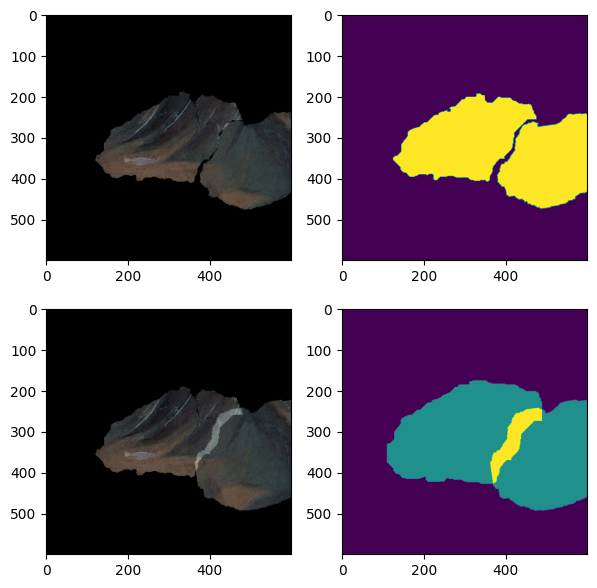

In [33]:
tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
# corr = compute_geom_morph_score(padded_frag0, shift_fragment(padded_frag1, y, x))
print(tr.confidence)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(frag3, tr.angle), x, y)
print(compute_content_score(padded_frag2, transformed))
# print(
#     compute_new_content_score(
#         padded_frag2, 
#         transformed, 
#         features1.detach().numpy()[0], 
#         features2.detach().numpy()[0], 
#         resized_mask1, resized_mask2, 
#         (x, y)
#     )
# )
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)

In [59]:

pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
pad

400

In [80]:
features1 = features1.detach().numpy()[0]
features2 = features2.detach().numpy()[0]

In [81]:
features1.shape

(32, 300, 300)

In [82]:

padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
padded_features1.shape

(32, 1100, 1100)

In [92]:
shift = (x, y)
shifted_features2 = padded_features2[
    :,
    pad - shift[1] // 2: -pad - shift[1] // 2, 
    pad - shift[0] // 2: -pad - shift[0] // 2
]

In [84]:

where = np.logical_and(resized_mask1, resized_mask2).transpose(2, 0, 1)

In [85]:
padded_features1.shape

(32, 1100, 1100)

In [102]:

features1_masked = features1 * where
features2_masked = shifted_features2 * where

In [103]:
features1_masked.shape

(32, 300, 300)

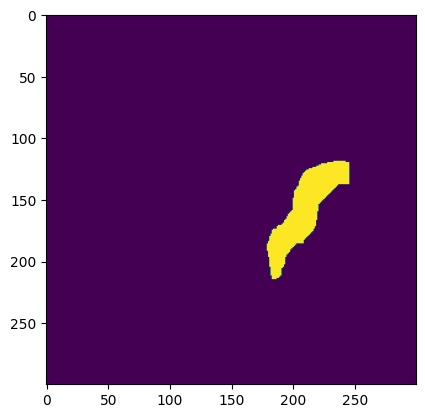

In [104]:
plt.imshow(where[0])

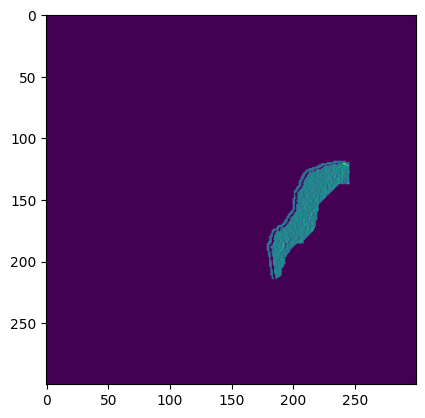

In [106]:
plt.imshow(features2_masked[6])

In [107]:

features_cov = (features1_masked * features2_masked).sum()
features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())

In [108]:
features_cross_corr

0.76188785